In [8]:
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

### Standard SigOpt config actions

In general, I would say to use these commands to setup SigOpt -- this will enable the tracking functionality present in SigOpt.  After you have run `sigopt config` once (either here or at the command line) you will not need to again.

### If you want to set things manually, this should be sufficient for our purposes

You also can set these quantities from the command line outside of the notebook.  This assumes that I have already created a `mccourt-pydata-demo` project in SigOpt that I can report results to.  If this quantity is unset, it will revert to using the directory name as the project.

If you want to change the project name or token, you will need to set the environment variable and then run `%reload sigopt`.

In general, I do not recommend putting your token directly into files you are going to share.  Since I was going to be showing the token no matter what, I was not worried.  But I will be rolling this token immediately after this session (you can do so from the [API tokens page](https://app.sigopt.com/tokens/info).

In [3]:
import os
os.environ['SIGOPT_PROJECT'] = 'mccourt-pydata-demo'
os.environ['SIGOPT_API_TOKEN'] = 'CTXVNRUMKZZIVPQDJWKVIZEWAPBKXXRGRLVDYQQKFUTGGVZM'  #  You must put your own token here
import sigopt
%load_ext sigopt

Again, define a problem we want to optimize -- in this case, the same problem as before.

In [6]:
def yf(x):
    x1, x2 = np.array(x).T
    return (
        .75 * np.exp(-.25 * ((9 * x1 - 2) ** 2 + (9 * x2 - 2) ** 2)) +
        .75 * np.exp(-(9 * x1 + 1) ** 2 / 49 - (9 * x2 + 1) / 10) +
        .5 * np.exp(-.25 * ((9 * x1 - 7) ** 2 + (9 * x2 - 3) ** 2)) -
        .2 * np.exp(-(9 * x1 - 4) ** 2 - (9 * x2 - 7) ** 2)
    )

Np = (35, 34)
X0, X1 = np.meshgrid(np.linspace(0, 1, Np[1]), np.linspace(0, 1, Np[0]))
xp = np.array([X0.reshape(-1), X1.reshape(-1)]).T
yp = yf(xp)
Y = yp.reshape(Np)

threshold = 0.85

# Actual Bayesian optimization

### I need to tell SigOpt what problem we want it to solve

We do that with an Experiment Create call.  We can do this in the [direct format](https://docs.sigopt.com/experiments) (which is what I will be demonstrating today) or through the [command line](https://docs.sigopt.com/tutorial/experiment).

After the experiment exists, we can view it on the SigOpt website and monitor the progress from there rather than having to do so from the notebook (or command line on 1 or more remote machines).

In [7]:
experiment = sigopt.create_experiment(
    name="Franke function",
    parameters=[
        dict(name="x1", type="double", bounds=dict(min=0, max=1)),
        dict(name="x2", type="double", bounds=dict(min=0, max=1)),
    ],
    metrics=[dict(name="y", objective="maximize", strategy="optimize")],
    parallel_bandwidth=1,
    budget=25,
)

Experiment created, view it on the SigOpt dashboard at https://app.sigopt.com/experiment/517677


### Now, I need to run the loop where I ask SigOpt what I should do and then tell SigOpt what happened

In a real problem, you would have parameters and metrics that actually mean something (as is the case with all of the [SigOpt examples](https://github.com/sigopt/sigopt-examples) on GitHub).  But for now, I didn't see the point in making up names.

We also added a `sleep` to simulate the real world and give us enough time to be able to monitor the experiment online.

`experiment.loop` will run until the stated `budget` is exhausted.  For a sequential experiment, this is just a basic loop, but when many machines are operating asynchronously, this leverages SigOpt's organizational structure.

In [9]:
for run in experiment.loop():
    with run:
        time.sleep(2)
        y = yf([run.params.x1, run.params.x2])
        run.log_metric("y", y)

Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/288506
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/288506
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/288507
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/288507
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/288508
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/288508
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/288509
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/288509
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/288510
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/288510
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/288511
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/288511
Run starte

### Now I pull all the data and plot the final result

This is just to compare to the other stuff we ran before -- in general, I find it easier to do this basic analysis from the web.  And, of course, in a real situation we would not be able to generate a plot of the true function (or, likely, a plot at all for higher dimensional problems).

In [13]:
all_runs = list(experiment.get_runs())

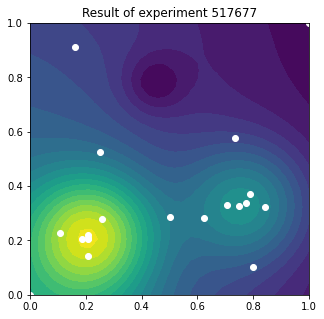

In [22]:
x1 = []
x2 = []
y = []
for run in all_runs:
    x1.append(run.assignments['x1'])
    x2.append(run.assignments['x2'])
    y.append(run.values['y'].value)
    
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.contourf(X0, X1, Y, 20)
ax.set_title(f'Result of experiment {experiment.id}')
ax.plot(x1, x2, 'ow');

# Suppose we wanted to try to run a search experiment

SigOpt has actually done some [new research](http://proceedings.mlr.press/v139/malkomes21a.html) on how to permit this for arbitrary problems without discretizing the domain.  To take advantage of that, we need to tell SigOpt the threshold that defines success for us.

We do that at the Experiment Create phase, and then the rest of the stuff is all the same (since the function evaluation has not changed, just the goal of the sequential decision process).

In [23]:
experiment = sigopt.create_experiment(
    name="Franke function -- search",
    parameters=[
        dict(name="x1", type="double", bounds=dict(min=0, max=1)),
        dict(name="x2", type="double", bounds=dict(min=0, max=1)),
    ],
    metrics=[dict(name="y", objective="maximize", strategy="constraint", threshold=threshold)],
    parallel_bandwidth=1,
    budget=25,
)

Experiment created, view it on the SigOpt dashboard at https://app.sigopt.com/experiment/517681


In [24]:
for run in experiment.loop():
    with run:
        time.sleep(2)
        y = yf([run.params.x1, run.params.x2])
        run.log_metric("y", y)

Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/288560
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/288560
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/288561
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/288561
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/288562
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/288562
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/288563
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/288563
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/288564
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/288564
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/288565
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/288565
Run starte

In [25]:
all_runs = list(experiment.get_runs())

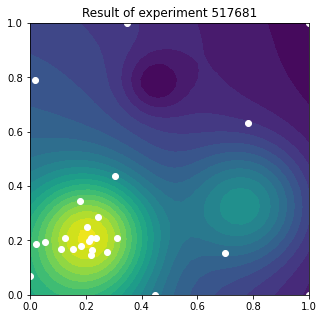

In [26]:
x1 = []
x2 = []
y = []
for run in all_runs:
    x1.append(run.assignments['x1'])
    x2.append(run.assignments['x2'])
    y.append(run.values['y'].value)
    
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.contourf(X0, X1, Y, 20)
ax.set_title(f'Result of experiment {experiment.id}')
ax.plot(x1, x2, 'ow');

# We also can run optimization/search on 2 metrics

Many real problems have many metrics that define success.  Our search algorithm has been tested to work on up to 6 metrics (though generally only 4 metrics are available to customers) -- this allows our users to find high performing outcomes under many different criteria all at once.  This is documented as the [All constraint](https://docs.sigopt.com/experiments/all_constraints) experiment type.

To run an optimization on 2 metrics, we use our [Multimetric functionality](https://docs.sigopt.com/advanced_experimentation/multimetric_optimization).  In doing so, we search for the Pareto frontier (not the optimum of each metric).  We do not presently allow for optimizing more than 2 metrics (though research is ongoing).

For this example, we create a second metric which is related to the first -- it is the distance from the true global maximum (which we found in a previous experiment).  Now we will be searching for the relationship between high metric values and distance to the true maximum.

We give ourselves a little more budget to explore problems with more than one metric.

In [47]:
experiment = sigopt.create_experiment(
    name="Franke function -- 2 metric optimization",
    parameters=[
        dict(name="x1", type="double", bounds=dict(min=0, max=1)),
        dict(name="x2", type="double", bounds=dict(min=0, max=1)),
    ],
    metrics=[
        dict(name="y", objective="maximize", strategy="optimize"),
        dict(name="distance from global max", objective="maximize", strategy="optimize"),
    ],
    parallel_bandwidth=1,
    budget=50,
)

Experiment created, view it on the SigOpt dashboard at https://app.sigopt.com/experiment/517687


In [48]:
global_max_location = [.206, .206]

for run in experiment.loop():
    with run:
        time.sleep(1.5)
        x1 = run.params.x1
        x2 = run.params.x2
        y = yf([x1, x2])
        distance_to_maximum = np.sqrt((x1 - global_max_location[0]) ** 2 + (x2 - global_max_location[1]) ** 2)
        run.log_metric("y", y)
        run.log_metric("distance from global max", distance_to_maximum)

Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/288771
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/288771
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/288772
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/288772
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/288773
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/288773
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/288774
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/288774
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/288775
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/288775
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/288776
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/288776
Run starte

In [49]:
all_runs = list(experiment.get_runs())
best_runs = list(experiment.get_best_runs())

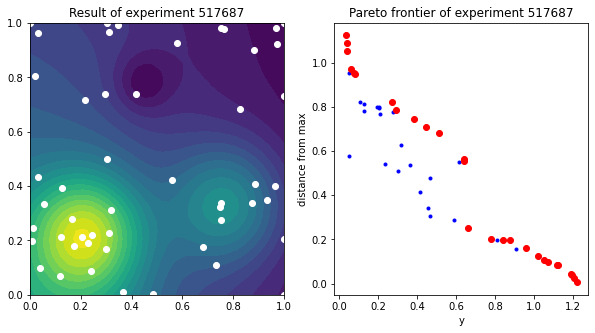

In [50]:
x1 = []
x2 = []
y = []
dist = []
for run in all_runs:
    x1.append(run.assignments['x1'])
    x2.append(run.assignments['x2'])
    y.append(run.values['y'].value)
    dist.append(run.values['distance from global max'].value)
y_best = []
dist_best = []
for run in best_runs:
    y_best.append(run.values['y'].value)
    dist_best.append(run.values['distance from global max'].value)
    
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.contourf(X0, X1, Y, 20)
ax.set_title(f'Result of experiment {experiment.id}')
ax.plot(x1, x2, 'ow')

ax = axes[1]
ax.set_title(f'Pareto frontier of experiment {experiment.id}')
ax.plot(y, dist, '.b')
ax.plot(y_best, dist_best, 'or')
ax.set_xlabel('y')
ax.set_ylabel('distance from max');

# We can also enforce metric constraints on problems

Often times, one or more metrics must meet certain performance standards while optimizing other metrics.  This can be accomplished with the same language as an [All constraints](https://docs.sigopt.com/experiments/all_constraints) experiment, but while still conducting optimization on at least one metric.  This is a [Metric constraints](https://docs.sigopt.com/advanced_experimentation/metric_constraints) style of experiment.

In [51]:
min_distance_from_max = .3

experiment = sigopt.create_experiment(
    name="Franke function -- constrained optimization",
    parameters=[
        dict(name="x1", type="double", bounds=dict(min=0, max=1)),
        dict(name="x2", type="double", bounds=dict(min=0, max=1)),
    ],
    metrics=[
        dict(name="y", objective="maximize", strategy="optimize"),
        dict(name="distance from global max", objective="maximize", strategy="constraint", threshold=min_distance_from_max),
    ],
    parallel_bandwidth=1,
    budget=25,
)

Experiment created, view it on the SigOpt dashboard at https://app.sigopt.com/experiment/517688


In [52]:
global_max_location = [.206, .206]

for run in experiment.loop():
    with run:
        time.sleep(1.5)
        x1 = run.params.x1
        x2 = run.params.x2
        y = yf([x1, x2])
        distance_to_maximum = np.sqrt((x1 - global_max_location[0]) ** 2 + (x2 - global_max_location[1]) ** 2)
        run.log_metric("y", y)
        run.log_metric("distance from global max", distance_to_maximum)

Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/288845
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/288845
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/288846
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/288846
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/288847
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/288847
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/288848
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/288848
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/288849
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/288849
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/288850
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/288850
Run starte

In [53]:
all_runs = list(experiment.get_runs())

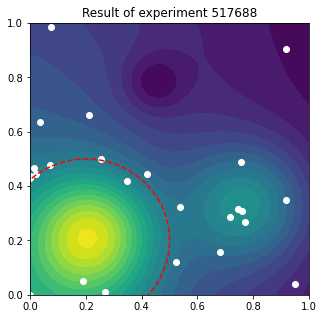

In [57]:
x1 = []
x2 = []
y = []
for run in all_runs:
    x1.append(run.assignments['x1'])
    x2.append(run.assignments['x2'])
    y.append(run.values['y'].value)
    
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.contourf(X0, X1, Y, 20)
ax.set_title(f'Result of experiment {experiment.id}')
ax.plot(x1, x2, 'ow')
t = np.linspace(-np.pi, np.pi, 200)
ax.plot(.2 + min_distance_from_max * np.cos(t), .2 + min_distance_from_max * np.sin(t), '--r')
ax.set_xlim((0, 1))
ax.set_ylim((0, 1));

### Parameter constraints can be enforced if they are linear and continuous

[Parameter constraint docs](https://docs.sigopt.com/advanced_experimentation/parameter_constraints)

### We also can allow failed observations, in the situation where no function value exists

If there are parameters which cause the computation to fail (like divide by 0, or the neural network doesn't converge) you can report this as a failure to SigOpt.  